## This notebook shows a multi-resolution comparison of a model trained on a single resolution vs a model trained on multiple resolutions.

### Findings:
1. As expected, performance drops significantly as the resolution decreases relative to the original resolution the model was trained on.
2. The models are not very useful for classifying resolutions over ~0.5m/px.
3. Training on multiple resamplings of the original resolution gives better performance on lower resolution imagery - while maintaining the same performance on the original resolution.

### Takeaway:
The multiresolution model is preferred over the original model for all resolutions, but still don't expect good performance on satellite data.

In [ ]:
import numpy as np
import torch
import os
import json
from torch.utils.data import DataLoader
from data import MemmapDataset
from models import *
from training_utils import TrainingSession, plot_comparison_metrics

# Training

### Setup

In [21]:
# Training Parameters
INIT_LR = 0.005
NUM_EPOCHS = 10
BATCH_SIZE = 64
INPUT_IMAGE_SIZE = 224
THRESHOLD = 0.5
LOSS = JaccardLoss()

# Load Training Data
training_dir = "A:\\Drone_Datasets\\training_data"
train_data = os.path.join(training_dir, "original_train")
trainLoader = DataLoader(MemmapDataset(np.load(os.path.join(train_data, "images.npy"), 'r'),
                                  np.load(os.path.join(train_data, "labels.npy"), 'r')),
                                    shuffle=True, batch_size=BATCH_SIZE)

multi_data_dir = os.path.join(training_dir, "multiresolution_train")
multires_data = DataLoader(MemmapDataset(np.load(os.path.join(multi_data_dir,  "images.npy"), 'r'),
                                  np.load(os.path.join(multi_data_dir, "labels.npy"), 'r')),
                                    shuffle=True, batch_size=BATCH_SIZE)

print(f"Training data loaded with {len(trainLoader)} samples.")
print(f"Multiresolution training data loaded with {len(multires_data)} samples.")

# Load Validation Data
valid_dir = "A:\\Drone_Datasets\\validation_data"
validation_dataloaders = []

one_meter_valid_path = os.path.join(valid_dir, "1m_valid")
one_meter_dataloader= DataLoader(MemmapDataset(np.load(os.path.join(one_meter_valid_path, "images.npy"), 'r'),
                                        np.load(os.path.join(one_meter_valid_path, "labels.npy"), 'r')),
                                    shuffle=False, batch_size=BATCH_SIZE)


half_meter_valid_path = os.path.join(valid_dir, "0_5m_valid")
half_meter_dataloader = DataLoader(MemmapDataset(np.load(os.path.join(half_meter_valid_path, "images.npy"), 'r'),
                                                  np.load(os.path.join(half_meter_valid_path, "labels.npy"), 'r')),
                                                    shuffle=False, batch_size=BATCH_SIZE)


one_tenth_meter_valid_path = os.path.join(valid_dir, "0_1m_valid")
one_tenth_meter_dataloader = DataLoader(MemmapDataset(np.load(os.path.join(one_tenth_meter_valid_path, "images.npy"), 'r'),
                                                       np.load(os.path.join(one_tenth_meter_valid_path, "labels.npy"), 'r')),
                                                        shuffle=False, batch_size=BATCH_SIZE)


zero_six_meter_valid_path = os.path.join(valid_dir, "0_06m_valid")
zero_six_meter_dataloader = DataLoader(MemmapDataset(np.load(os.path.join(zero_six_meter_valid_path, "images.npy"), 'r'),
                                                       np.load(os.path.join(zero_six_meter_valid_path, "labels.npy"), 'r')),
                                                        shuffle=False, batch_size=BATCH_SIZE)


original_valid_path = os.path.join(valid_dir, "original_valid")
original_valid_dataloader = DataLoader(MemmapDataset(np.load(os.path.join(original_valid_path, "images.npy"), 'r'),
                                                     np.load(os.path.join(original_valid_path, "labels.npy"), 'r')),
                                      shuffle=False, batch_size=BATCH_SIZE)

two_meter_valid_path = os.path.join(valid_dir, "2m_valid")
two_meter_dataloader = DataLoader(MemmapDataset(np.load(os.path.join(two_meter_valid_path, "images.npy"), 'r'),
                                                  np.load(os.path.join(two_meter_valid_path, "labels.npy"), 'r')),
                                                shuffle=False, batch_size=BATCH_SIZE)

validation_dataloaders.append(two_meter_dataloader)
validation_dataloaders.append(one_meter_dataloader)
validation_dataloaders.append(half_meter_dataloader)
validation_dataloaders.append(one_tenth_meter_dataloader)
validation_dataloaders.append(zero_six_meter_dataloader)
validation_dataloaders.append(original_valid_dataloader)

validation_resolutions = [
    "2m",
    "1m",
    "0.5m",
    "0.1m",
    "0.06m",
    "original 0.03m"
]

Training data loaded with 9564 samples.
Multiresolution training data loaded with 13253 samples.


## Original Model

In [ ]:
original_machine = TrainingSession(ResNet_UNet(), 
                                   trainLoader, 
                                   validation_dataloaders, 
                                   LOSS,
                                   init_lr=INIT_LR, 
                                   num_epochs=NUM_EPOCHS, 
                                   validation_dataset_names=validation_resolutions, 
                                   epoch_print_frequency=5)
original_machine.learn()

# Save the model and metrics
torch.save(original_machine.model.to("cpu").state_dict(), "original_model.pth")
with open("original_metrics.json", "w") as f:
    json.dump(original_machine.get_metrics(), f)


Using CUDA device.
Learning...
Epoch 1/10:


100%|██████████| 9564/9564 [19:23<00:00,  8.22batches/s]


Train loss: 0.232500, Average Test loss: 0.4130

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.4653161021096129
  Loss: 0.6698048710823059
  Precision: 0.7816972287720574
  Recall: 0.36373628957361015
  IOU: 0.3301951370348913
  Accuracy: 0.666437175865566
  Specificity: 0.9161888175511287

 Validation Metrics for 1m:
  Landmass Captured: 1.3485845053346266
  Loss: 0.558315634727478
  Precision: 0.5335435921021506
  Recall: 0.7195286380576136
  IOU: 0.441684437335778
  Accuracy: 0.7947414084082243
  Specificity: 0.8166621156436089

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1385093034887588
  Loss: 0.47433950503667194
  Precision: 0.6686674294333239
  Recall: 0.761284093628444
  IOU: 0.5527665952096504
  Accuracy: 0.7450408771776096
  Specificity: 0.7335684042556411

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2372498018656504
  Loss: 0.3267292238417126
  Precision: 0.7286167103055272
  Recall: 0.901480872478569
  IOU: 0.6748778625105

100%|██████████| 9564/9564 [19:14<00:00,  8.29batches/s]


Train loss: 0.088303, Average Test loss: 0.3827

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.8665509313685151
  Loss: 0.5531413555145264
  Precision: 0.6652575255997258
  Recall: 0.5764795284083561
  IOU: 0.44685862122482806
  Accuracy: 0.6774007991868622
  Specificity: 0.7606686542770401

 Validation Metrics for 1m:
  Landmass Captured: 1.9431725311635593
  Loss: 0.588594913482666
  Precision: 0.4414914687355149
  Recall: 0.8578941148540246
  IOU: 0.4114050620039013
  Accuracy: 0.7230086574231621
  Specificity: 0.6836963899950094

 Validation Metrics for 0.5m:
  Landmass Captured: 1.2533272490629672
  Loss: 0.4446100393931071
  Precision: 0.6613508525052819
  Recall: 0.8288890306659864
  IOU: 0.5819059277211484
  Accuracy: 0.7534818068649861
  Specificity: 0.7002221996278514

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2106983180343758
  Loss: 0.30955140193303426
  Precision: 0.746456713752059
  Recall: 0.9037338882827315
  IOU: 0.6914755040

100%|██████████| 9564/9564 [19:14<00:00,  8.28batches/s]


Train loss: 0.052411, Average Test loss: 0.3842

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.6539295231916344
  Loss: 0.5608205199241638
  Precision: 0.7718148646540254
  Recall: 0.5047124998530501
  IOU: 0.4391794628248381
  Accuracy: 0.708633689057052
  Specificity: 0.8768844427448669

 Validation Metrics for 1m:
  Landmass Captured: 1.943291527463448
  Loss: 0.5943211317062378
  Precision: 0.4371108221412054
  Recall: 0.849433767162711
  IOU: 0.40567882596851296
  Accuracy: 0.7191632084278468
  Specificity: 0.6811959493887352

 Validation Metrics for 0.5m:
  Landmass Captured: 1.2719486176888921
  Loss: 0.4541664719581604
  Precision: 0.6509472817892897
  Recall: 0.8279715162081209
  IOU: 0.573396556570593
  Accuracy: 0.7450141801319176
  Specificity: 0.6864219796627149

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2513369986847007
  Loss: 0.30686556100845336
  Precision: 0.7374004577741676
  Recall: 0.9227364731966828
  IOU: 0.694517620469

100%|██████████| 9564/9564 [20:07<00:00,  7.92batches/s]


Train loss: 0.036304, Average Test loss: 0.3974

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.572808719713624
  Loss: 0.6599012613296509
  Precision: 0.6968422916785836
  Recall: 0.3991573249385749
  IOU: 0.3400987163007299
  Accuracy: 0.6498682548845228
  Specificity: 0.8567241774238652

 Validation Metrics for 1m:
  Landmass Captured: 1.5809101869813558
  Loss: 0.5463268756866455
  Precision: 0.5094973700801362
  Recall: 0.8054696014379281
  IOU: 0.4536730720377176
  Accuracy: 0.7811007037890708
  Specificity: 0.7739984066739634

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1257001902670933
  Loss: 0.47580641508102417
  Precision: 0.6732791727651772
  Recall: 0.7579104765058955
  IOU: 0.5541133131507299
  Accuracy: 0.747550105175374
  Specificity: 0.7402326454140732

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2672903065669252
  Loss: 0.3213155053910755
  Precision: 0.7241178587469475
  Recall: 0.917667550344303
  IOU: 0.679943739394

100%|██████████| 9564/9564 [20:01<00:00,  7.96batches/s]


Train loss: 0.027200, Average Test loss: 0.3927

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.44151687572740206
  Loss: 0.6834530830383301
  Precision: 0.7850082382496789
  Recall: 0.34659435322937115
  IOU: 0.31654693261582956
  Accuracy: 0.6616973029371578
  Specificity: 0.9216816097942729

 Validation Metrics for 1m:
  Landmass Captured: 1.5380558960795583
  Loss: 0.5550771355628967
  Precision: 0.5081233811529796
  Recall: 0.7815221385506101
  IOU: 0.4449229375821564
  Accuracy: 0.7799631608175996
  Specificity: 0.7795087978863332

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1632490527712211
  Loss: 0.4424779812494914
  Precision: 0.6833624338216336
  Recall: 0.7949206962512193
  IOU: 0.5809429432028946
  Accuracy: 0.7626469400552829
  Specificity: 0.7398522065957589

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2389131694776416
  Loss: 0.30716898838678997
  Precision: 0.7403183110230314
  Recall: 0.9171901092436476
  IOU: 0.693935

100%|██████████| 9564/9564 [20:00<00:00,  7.96batches/s]


Train loss: 0.021489, Average Test loss: 0.4236

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.4374909074744601
  Loss: 0.7144901752471924
  Precision: 0.7297627402444752
  Recall: 0.31926456347060417
  IOU: 0.28550978536909094
  Accuracy: 0.6388069412335247
  Specificity: 0.9024541208764562

 Validation Metrics for 1m:
  Landmass Captured: 1.5788702236831076
  Loss: 0.6118555068969727
  Precision: 0.45671137445146
  Recall: 0.7210879517114523
  IOU: 0.38814450707098835
  Accuracy: 0.7434752407570097
  Specificity: 0.75

 Validation Metrics for 0.5m:
  Landmass Captured: 1.035018063053801
  Loss: 0.5039676229159037
  Precision: 0.6747921634952371
  Recall: 0.6984221078863699
  IOU: 0.5225379308251438
  Accuracy: 0.7358379687599426
  Specificity: 0.7622645366264967

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2712061150690475
  Loss: 0.3298661101432074
  Precision: 0.7175607811546314
  Recall: 0.9121676603262763
  IOU: 0.6711860508668704
  Accur

100%|██████████| 9564/9564 [20:04<00:00,  7.94batches/s]


Train loss: 0.017641, Average Test loss: 0.4179

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.41505027891092483
  Loss: 0.734350323677063
  Precision: 0.7155944468296938
  Recall: 0.29700768435491187
  IOU: 0.26564970085501943
  Accuracy: 0.6288281614707429
  Specificity: 0.902605718757058

 Validation Metrics for 1m:
  Landmass Captured: 1.6703499389302008
  Loss: 0.6207362413406372
  Precision: 0.4395970887788049
  Recall: 0.7342808538002827
  IOU: 0.379263818648276
  Accuracy: 0.7287851347073435
  Specificity: 0.7271834113046483

 Validation Metrics for 0.5m:
  Landmass Captured: 1.0859740220843508
  Loss: 0.4766201575597127
  Precision: 0.6773158692997474
  Recall: 0.7355474328103395
  IOU: 0.5446778399309409
  Accuracy: 0.7454804648465326
  Specificity: 0.7524960975897826

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2040226228339586
  Loss: 0.31405576978410993
  Precision: 0.7459059172044451
  Recall: 0.8980876023926445
  IOU: 0.687697002

100%|██████████| 9564/9564 [20:11<00:00,  7.89batches/s]


Train loss: 0.014763, Average Test loss: 0.4058

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.4335157287833723
  Loss: 0.7356921434402466
  Precision: 0.6912813328124102
  Recall: 0.29968130009886745
  IOU: 0.2643078250680653
  Accuracy: 0.6228977118703265
  Specificity: 0.8895762725262049

 Validation Metrics for 1m:
  Landmass Captured: 1.6061244925818157
  Loss: 0.576086163520813
  Precision: 0.4830697976919267
  Recall: 0.7758702429454168
  IOU: 0.423913909767408
  Accuracy: 0.7620506979761624
  Specificity: 0.7580230017209275

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1378137155441814
  Loss: 0.4816657304763794
  Precision: 0.6593374386502215
  Recall: 0.7502031991788465
  IOU: 0.5406439165143838
  Accuracy: 0.7361552767769736
  Specificity: 0.7262333253227153

 Validation Metrics for 0.1m:
  Landmass Captured: 1.2155527143358542
  Loss: 0.2995461810202826
  Precision: 0.7514774045726887
  Recall: 0.9134603983955855
  IOU: 0.70153274669

100%|██████████| 9564/9564 [19:18<00:00,  8.25batches/s]


Train loss: 0.012666, Average Test loss: 0.4010

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.3773865124231452
  Loss: 0.733407735824585
  Precision: 0.7682103378339119
  Recall: 0.28991222452806004
  IOU: 0.2665922553333465
  Accuracy: 0.6394397072363643
  Specificity: 0.9278269366437625

 Validation Metrics for 1m:
  Landmass Captured: 1.3435080782771132
  Loss: 0.5663456320762634
  Precision: 0.5276250274435328
  Recall: 0.7088685526099423
  IOU: 0.43365432395619957
  Accuracy: 0.7910755665010201
  Specificity: 0.8150347402778699

 Validation Metrics for 0.5m:
  Landmass Captured: 1.0724619040983612
  Loss: 0.4653928478558858
  Precision: 0.6901174343645435
  Recall: 0.7401246376157931
  IOU: 0.55550848303193
  Accuracy: 0.7548629192175466
  Specificity: 0.7652724673710877

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1950208128183655
  Loss: 0.30014344169980006
  Precision: 0.75739295526437
  Recall: 0.9051003428153716
  IOU: 0.701671433168

100%|██████████| 9564/9564 [19:54<00:00,  8.01batches/s]


Train loss: 0.011016, Average Test loss: 0.4095

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.37937295372253504
  Loss: 0.754166305065155
  Precision: 0.7174583267224182
  Recall: 0.2721842928182641
  IOU: 0.24583370441463828
  Accuracy: 0.6225128921061611
  Specificity: 0.911561061313451

 Validation Metrics for 1m:
  Landmass Captured: 1.5387337633665026
  Loss: 0.5759595632553101
  Precision: 0.4912907850504552
  Recall: 0.755965736268223
  IOU: 0.4240404301161824
  Accuracy: 0.7682752254509895
  Specificity: 0.7718628171237162

 Validation Metrics for 0.5m:
  Landmass Captured: 1.096751174512706
  Loss: 0.4774756232897441
  Precision: 0.6713334973826764
  Recall: 0.7362858120939205
  IOU: 0.5412014330459174
  Accuracy: 0.7416307057029725
  Specificity: 0.7454057675250756

 Validation Metrics for 0.1m:
  Landmass Captured: 1.213252030945113
  Loss: 0.308666691893623
  Precision: 0.7465302772816071
  Recall: 0.9057293797950847
  IOU: 0.69270645110253

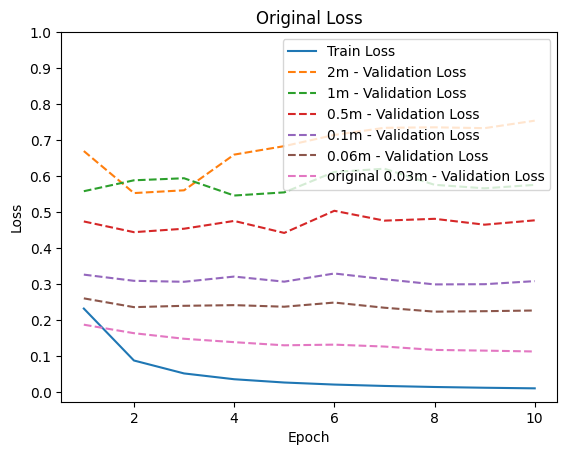

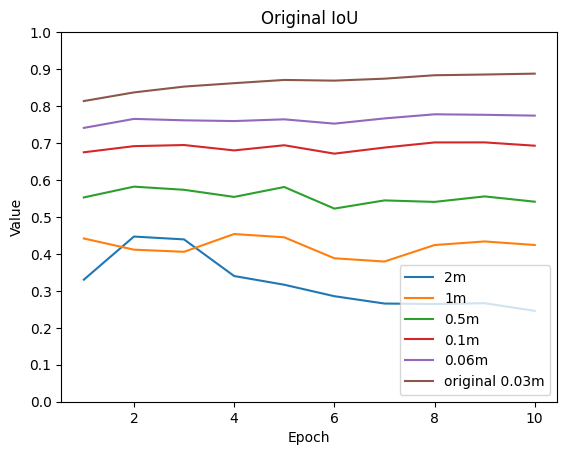

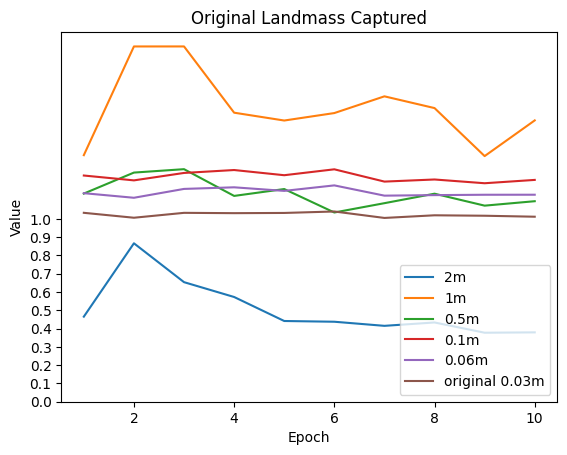

In [ ]:
original_machine.plot_loss(title='Original Model Loss', y_max=1.0)
original_machine.plot_metrics('Original Model IoU', metrics = ['IOU'])
original_machine.plot_metrics('Original Model Landmass Captured', metrics = ['Landmass Captured'])

## MultiRes Model

In [5]:
# Train Multiresolution Model
multires_machine = TrainingSession(ResNet_UNet(), 
                                   multires_data, 
                                   validation_dataloaders, 
                                   LOSS, 
                                   init_lr=INIT_LR,
                                   num_epochs=NUM_EPOCHS, 
                                   validation_dataset_names=validation_resolutions,
                                   epoch_print_frequency=5)
multires_machine.learn()

# Save the model and metrics
torch.save(multires_machine.model.to("cpu").state_dict(), "multires_model.pth")
with open("multires_metrics.json", "w") as f:
    json.dump(multires_machine.get_metrics(), f)

Using CUDA device.
Learning...
Epoch 1/10:


100%|██████████| 13253/13253 [28:28<00:00,  7.76batches/s]


Train loss: 0.220770, Average Test loss: 0.4108

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.7128320057633754
  Loss: 0.6536397933959961
  Precision: 0.6181506650203488
  Recall: 0.44063756421710965
  IOU: 0.34636024005441773
  Accuracy: 0.6240714287367692
  Specificity: 0.775418553503115

 Validation Metrics for 1m:
  Landmass Captured: 1.748760268108393
  Loss: 0.5986079573631287
  Precision: 0.45021061389613587
  Recall: 0.7873104285714619
  IOU: 0.40139208121397435
  Accuracy: 0.7350247812548898
  Specificity: 0.7197861685460187

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1922638640363472
  Loss: 0.4919099609057109
  Precision: 0.6352748845591154
  Recall: 0.7574152885896954
  IOU: 0.5278712343244448
  Accuracy: 0.7195871583421056
  Specificity: 0.6928694070887335

 Validation Metrics for 0.1m:
  Landmass Captured: 1.191065679760311
  Loss: 0.2987474146343413
  Precision: 0.7592230603372757
  Recall: 0.9042845291323989
  IOU: 0.702749282

100%|██████████| 13253/13253 [28:37<00:00,  7.72batches/s] 


Train loss: 0.084059, Average Test loss: 0.3693

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.9104753609089733
  Loss: 0.5045158863067627
  Precision: 0.6952183041522898
  Recall: 0.6329791044578724
  IOU: 0.49548413470098285
  Accuracy: 0.7086279897131267
  Specificity: 0.7710441694531239

 Validation Metrics for 1m:
  Landmass Captured: 1.6822768856797308
  Loss: 0.5627342462539673
  Precision: 0.485081309963707
  Recall: 0.8160410563419168
  IOU: 0.4372657842687885
  Accuracy: 0.7629961140440517
  Specificity: 0.7475362038759392

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1133463883521872
  Loss: 0.48256274064381915
  Precision: 0.6721519784009024
  Recall: 0.7483379663527915
  IOU: 0.5482295665333925
  Accuracy: 0.7447389893457383
  Specificity: 0.7421970564679004

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1697052981722964
  Loss: 0.2746898060753232
  Precision: 0.7813597822045895
  Recall: 0.9139606739057343
  IOU: 0.727823682

100%|██████████| 13253/13253 [27:05<00:00,  8.15batches/s] 


Train loss: 0.049729, Average Test loss: 0.3843

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.5902368410031389
  Loss: 0.657196581363678
  Precision: 0.6878095222831148
  Recall: 0.40597051964426367
  IOU: 0.3428033984606069
  Accuracy: 0.6481495686880009
  Specificity: 0.8479660253195271

 Validation Metrics for 1m:
  Landmass Captured: 1.8819167534815773
  Loss: 0.5869354009628296
  Precision: 0.4476483473131809
  Recall: 0.842436924477015
  IOU: 0.41306460230508635
  Accuracy: 0.7298559916551366
  Specificity: 0.6970443607631824

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1085391916792275
  Loss: 0.46353453397750854
  Precision: 0.6852264641437541
  Recall: 0.759600403536936
  IOU: 0.563109608566201
  Accuracy: 0.756052648185064
  Specificity: 0.7535468926969567

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1783591578491606
  Loss: 0.25554016942069646
  Precision: 0.7898063257914267
  Recall: 0.9306755235886442
  IOU: 0.74592267762

100%|██████████| 13253/13253 [26:57<00:00,  8.19batches/s]


Train loss: 0.034222, Average Test loss: 0.3954

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.5269805081968658
  Loss: 0.6909983158111572
  Precision: 0.6840054916542454
  Recall: 0.3604575616014013
  IOU: 0.30900168972535735
  Accuracy: 0.6355955653683292
  Specificity: 0.8626056929924878

 Validation Metrics for 1m:
  Landmass Captured: 1.3981528256756595
  Loss: 0.5446009039878845
  Precision: 0.5367008608520092
  Recall: 0.7503898251427955
  IOU: 0.45539912287151113
  Accuracy: 0.7974842916806631
  Specificity: 0.8112099400341933

 Validation Metrics for 0.5m:
  Landmass Captured: 1.0295918185999537
  Loss: 0.5130792856216431
  Precision: 0.6722362549185977
  Recall: 0.6921289302052752
  IOU: 0.5174939432614695
  Accuracy: 0.7328741816517196
  Specificity: 0.7616522756733322

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1619827880354345
  Loss: 0.2777703330630348
  Precision: 0.7815202698779242
  Recall: 0.9081130994166592
  IOU: 0.72424838

100%|██████████| 13253/13253 [27:00<00:00,  8.18batches/s]


Train loss: 0.025728, Average Test loss: 0.3709

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.5578962890005055
  Loss: 0.6681826114654541
  Precision: 0.6957281018406664
  Recall: 0.38814411818299377
  IOU: 0.33181739831364965
  Accuracy: 0.646652190850931
  Specificity: 0.859941341461348

 Validation Metrics for 1m:
  Landmass Captured: 1.4421838889487613
  Loss: 0.5289742350578308
  Precision: 0.5422282119229699
  Recall: 0.7819927730798382
  IOU: 0.4710257641379497
  Accuracy: 0.801811601965047
  Specificity: 0.8075877853470931

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1051095055377977
  Loss: 0.4499889810880025
  Precision: 0.6998893726089777
  Recall: 0.7734544185479187
  IOU: 0.5808218730683998
  Accuracy: 0.7689416066484109
  Specificity: 0.7657542381697042

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1446559451314853
  Loss: 0.2510467217082069
  Precision: 0.8032743074779093
  Recall: 0.9194727111651406
  IOU: 0.75047771313

100%|██████████| 13253/13253 [27:48<00:00,  7.94batches/s]


Train loss: 0.020378, Average Test loss: 0.3671

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.643562528655232
  Loss: 0.6095855236053467
  Precision: 0.7170956552558582
  Recall: 0.46149590964931875
  IOU: 0.39041445995078367
  Accuracy: 0.6742458008511851
  Specificity: 0.8497809281956326

 Validation Metrics for 1m:
  Landmass Captured: 1.615951977883153
  Loss: 0.5562084913253784
  Precision: 0.4975948514172144
  Recall: 0.8040893377818491
  IOU: 0.44379157751927456
  Accuracy: 0.7725696438367455
  Specificity: 0.7633832519883994

 Validation Metrics for 0.5m:
  Landmass Captured: 1.0939203036343337
  Loss: 0.46617595354715985
  Precision: 0.6878423094235073
  Recall: 0.7524446607457317
  IOU: 0.5609081839327246
  Accuracy: 0.75617990839627
  Specificity: 0.7588180883523834

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1654115448108213
  Loss: 0.251965526172093
  Precision: 0.7956700883411439
  Recall: 0.927283102876798
  IOU: 0.748939346820

100%|██████████| 13253/13253 [27:27<00:00,  8.04batches/s]


Train loss: 0.016693, Average Test loss: 0.3706

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.6155701325782067
  Loss: 0.6416672468185425
  Precision: 0.6923546949358355
  Recall: 0.42619284750714176
  IOU: 0.3583327722818867
  Accuracy: 0.654981101755899
  Specificity: 0.8437491146388473

 Validation Metrics for 1m:
  Landmass Captured: 1.6038171618110189
  Loss: 0.5448800325393677
  Precision: 0.5077882999140741
  Recall: 0.8143996565197917
  IOU: 0.4551199451573526
  Accuracy: 0.7799617164308783
  Specificity: 0.7699248038300028

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1820302635983762
  Loss: 0.4729676842689514
  Precision: 0.6544866476869394
  Recall: 0.7736230128415554
  IOU: 0.5492892928287226
  Accuracy: 0.7372410753132201
  Specificity: 0.7115447613579128

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1761977491006812
  Loss: 0.2397122689655849
  Precision: 0.7994288230752543
  Recall: 0.9402863840049722
  IOU: 0.7608040583

100%|██████████| 13253/13253 [26:19<00:00,  8.39batches/s]


Train loss: 0.013993, Average Test loss: 0.3501

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.5254007507670785
  Loss: 0.6054073572158813
  Precision: 0.8214759932721182
  Recall: 0.43160409417137885
  IOU: 0.3945926293510498
  Accuracy: 0.7006373020127344
  Specificity: 0.9226105114696531

 Validation Metrics for 1m:
  Landmass Captured: 1.3413713837099304
  Loss: 0.48826879262924194
  Precision: 0.590865397256206
  Recall: 0.7925699907796577
  IOU: 0.5117311661293213
  Accuracy: 0.8293366074017634
  Specificity: 0.8400522107514635

 Validation Metrics for 0.5m:
  Landmass Captured: 1.088889929721827
  Loss: 0.4667869806289673
  Precision: 0.6909948076232953
  Recall: 0.7524172847250247
  IOU: 0.5629874205145134
  Accuracy: 0.7582394864831646
  Specificity: 0.762351667886919

 Validation Metrics for 0.1m:
  Landmass Captured: 1.1207270126782414
  Loss: 0.23581191301345825
  Precision: 0.8203040599032293
  Recall: 0.9193369191433354
  IOU: 0.7652276504

100%|██████████| 13253/13253 [26:24<00:00,  8.36batches/s]


Train loss: 0.012029, Average Test loss: 0.3674

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.4043515908797009
  Loss: 0.7201088070869446
  Precision: 0.75950893514855
  Recall: 0.3071086233921557
  IOU: 0.2798911826300684
  Accuracy: 0.6427976265358315
  Specificity: 0.9197670469659645

 Validation Metrics for 1m:
  Landmass Captured: 1.2336730902216475
  Loss: 0.5257319211959839
  Precision: 0.5824611451907848
  Recall: 0.7185666409215552
  IOU: 0.47426808938309195
  Accuracy: 0.8202399836423251
  Specificity: 0.8498726045340402

 Validation Metrics for 0.5m:
  Landmass Captured: 0.9879577399169486
  Loss: 0.46563156445821124
  Precision: 0.725454403356442
  Recall: 0.7167183122469525
  IOU: 0.5637948929970835
  Accuracy: 0.7704647048971099
  Specificity: 0.8084254167381718

 Validation Metrics for 0.1m:
  Landmass Captured: 1.086221229721353
  Loss: 0.21632558334441412
  Precision: 0.8444550156554995
  Recall: 0.9172649637588545
  IOU: 0.78468715394

100%|██████████| 13253/13253 [26:20<00:00,  8.39batches/s]


Train loss: 0.010569, Average Test loss: 0.3710

All Test Datasets Metrics:

 Validation Metrics for 2m:
  Landmass Captured: 0.49467600484346896
  Loss: 0.7040668725967407
  Precision: 0.6899812518451847
  Recall: 0.3413171373101117
  IOU: 0.29593317443862655
  Accuracy: 0.6328938032109735
  Specificity: 0.8734671086111688

 Validation Metrics for 1m:
  Landmass Captured: 1.4534693595753854
  Loss: 0.5364579558372498
  Precision: 0.5346366237443905
  Recall: 0.7770779261115303
  IOU: 0.4635420655832125
  Accuracy: 0.7970464177646213
  Specificity: 0.8028662201956333

 Validation Metrics for 0.5m:
  Landmass Captured: 1.1108355913035646
  Loss: 0.4535367290178935
  Precision: 0.6878415940779168
  Recall: 0.7640789184676521
  IOU: 0.5673474194291785
  Accuracy: 0.7588097260746187
  Specificity: 0.7550881314080128

 Validation Metrics for 0.1m:
  Landmass Captured: 1.153632539556335
  Loss: 0.23531248853320166
  Precision: 0.809652851035837
  Recall: 0.9340418758121796
  IOU: 0.765865058

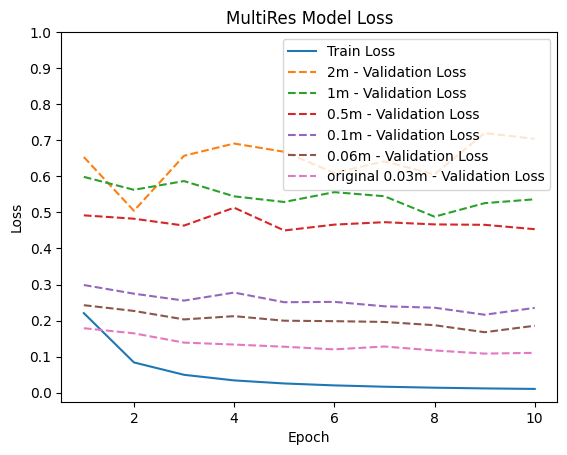

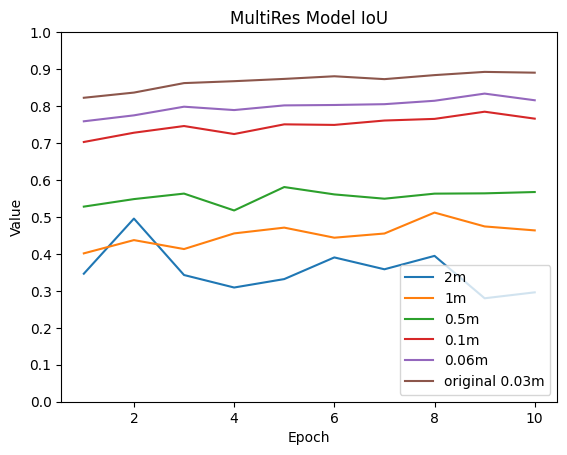

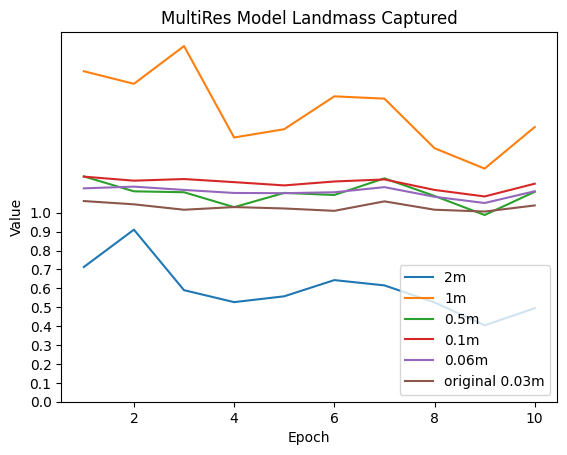

In [8]:
multires_machine.plot_loss(title='MultiRes Model Loss', y_max=1.0)
multires_machine.plot_metrics('MultiRes Model IoU', metrics=['IOU'])
multires_machine.plot_metrics('MultiRes Model Landmass Captured', metrics = ['Landmass Captured'])

# Comparisons

### Gather metrics

In [65]:
metrics_list = original_machine.get_available_metrics()
print(f"Available metrics: {metrics_list}")

# Collect final metrics for each resolution
titles = ['Original', 'MultiRes']

final_two_meter_metrics = [[original_machine.get_metrics()[-1][0], multires_machine.get_metrics()[-1][0]]]
final_one_meter_metrics = [[original_machine.get_metrics()[-1][1], multires_machine.get_metrics()[-1][1]]]
final_half_meter_metrics = [[original_machine.get_metrics()[-1][2], multires_machine.get_metrics()[-1][2]]]
final_tenth_meter_metrics = [[original_machine.get_metrics()[-1][3], multires_machine.get_metrics()[-1][3]]]
final_zero_six_meter_metrics = [[original_machine.get_metrics()[-1][4], multires_machine.get_metrics()[-1][4]]]
final_original_metrics = [[original_machine.get_metrics()[-1][-1], multires_machine.get_metrics()[-1][-1]]]

# Extract IoU values
original_iou_values = [
    [{'IoU': final_two_meter_metrics[0][0].get('IOU')},
    {'IoU': final_one_meter_metrics[0][0].get('IOU')},
    {'IoU': final_half_meter_metrics[0][0].get('IOU')},
    {'IoU': final_tenth_meter_metrics[0][0].get('IOU')},
    {'IoU': final_zero_six_meter_metrics[0][0].get('IOU')},
    {'IoU': final_original_metrics[0][0].get('IOU')}]
]

multires_iou_values = [
    [{'IoU': final_two_meter_metrics[0][1].get('IOU')},
    {'IoU': final_one_meter_metrics[0][1].get('IOU')},
    {'IoU': final_half_meter_metrics[0][1].get('IOU')},
    {'IoU': final_tenth_meter_metrics[0][1].get('IOU')},
    {'IoU': final_zero_six_meter_metrics[0][1].get('IOU')},
    {'IoU': final_original_metrics[0][1].get('IOU')}]
]

original_iou_values[0].reverse()
multires_iou_values[0].reverse()
validation_resolutions.reverse()


Available metrics: ['Landmass Captured', 'Loss', 'Precision', 'Recall', 'IOU', 'Accuracy', 'Specificity']


## IoU for each model

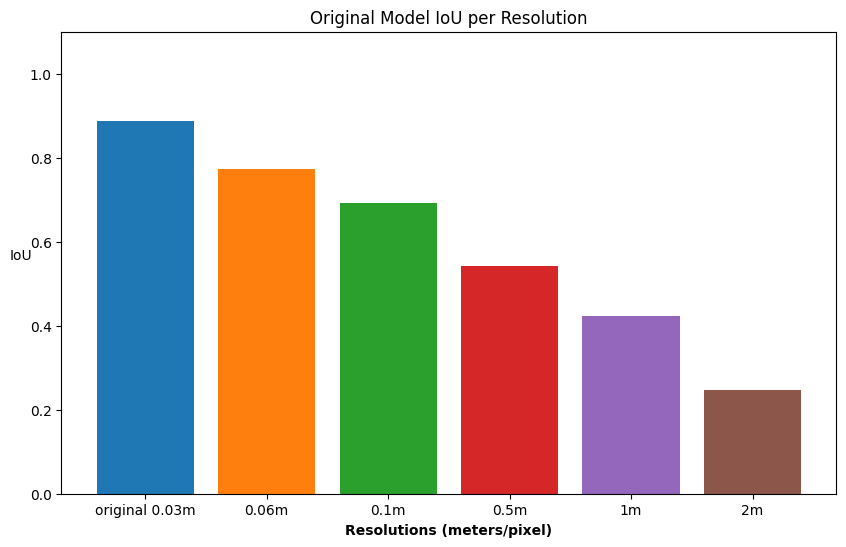

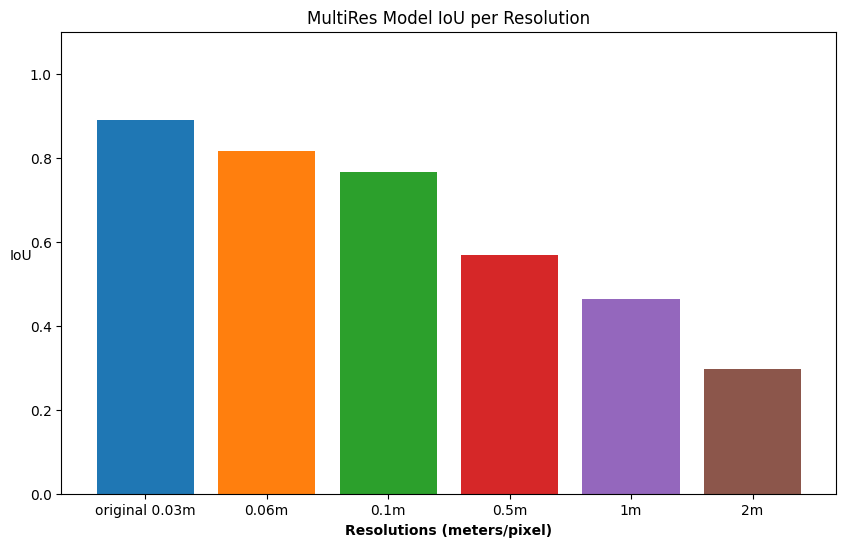

In [66]:
plot_comparison_metrics('Original Model IoU per Resolution', original_iou_values, validation_resolutions, metrics_wanted=['IoU'], 
                        x_label='Resolutions (meters/pixel)', y_label='IoU', single_metric=True)
plot_comparison_metrics('MultiRes Model IoU per Resolution', multires_iou_values, validation_resolutions, metrics_wanted=['IoU'], 
                        x_label='Resolutions (meters/pixel)', y_label='IoU', single_metric=True)

## All metrics comparison

[[0.37937295372253504, 0.754166305065155, 0.7174583267224182, 0.2721842928182641, 0.24583370441463828, 0.6225128921061611, 0.911561061313451], [0.49467600484346896, 0.7040668725967407, 0.6899812518451847, 0.3413171373101117, 0.29593317443862655, 0.6328938032109735, 0.8734671086111688]]


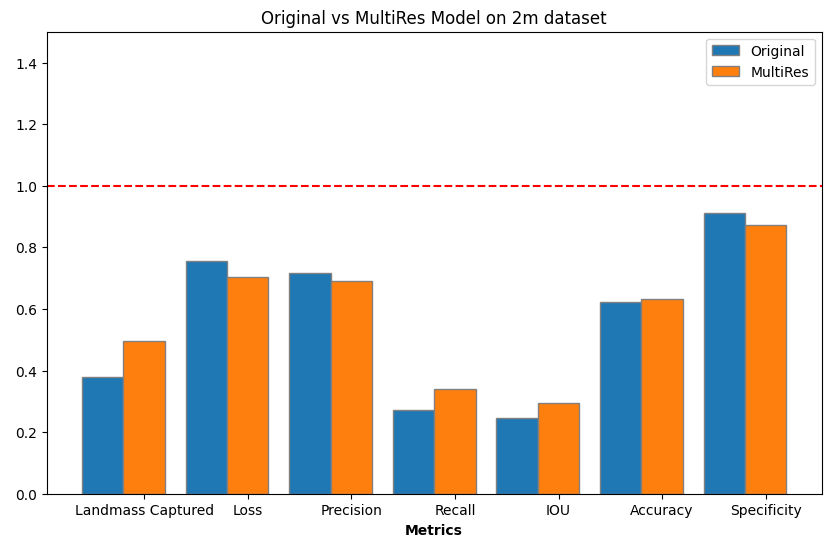

[[1.5387337633665026, 0.5759595632553101, 0.4912907850504552, 0.755965736268223, 0.4240404301161824, 0.7682752254509895, 0.7718628171237162], [1.4534693595753854, 0.5364579558372498, 0.5346366237443905, 0.7770779261115303, 0.4635420655832125, 0.7970464177646213, 0.8028662201956333]]


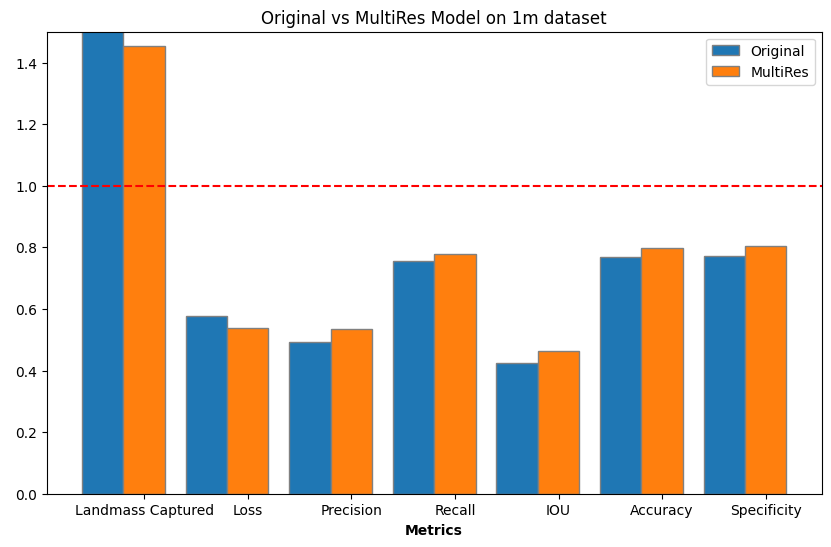

[[1.096751174512706, 0.4774756232897441, 0.6713334973826764, 0.7362858120939205, 0.5412014330459174, 0.7416307057029725, 0.7454057675250756], [1.1108355913035646, 0.4535367290178935, 0.6878415940779168, 0.7640789184676521, 0.5673474194291785, 0.7588097260746187, 0.7550881314080128]]


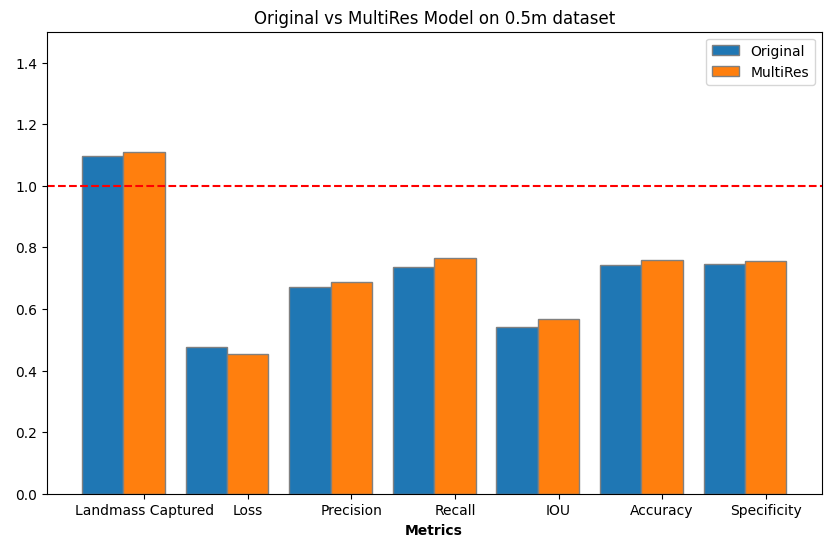

[[1.213252030945113, 0.308666691893623, 0.7465302772816071, 0.9057293797950847, 0.6927064511025375, 0.8468473127970763, 0.8105783079192403], [1.153632539556335, 0.23531248853320166, 0.809652851035837, 0.9340418758121796, 0.765865058274682, 0.8911565554168037, 0.8647409085035619]]


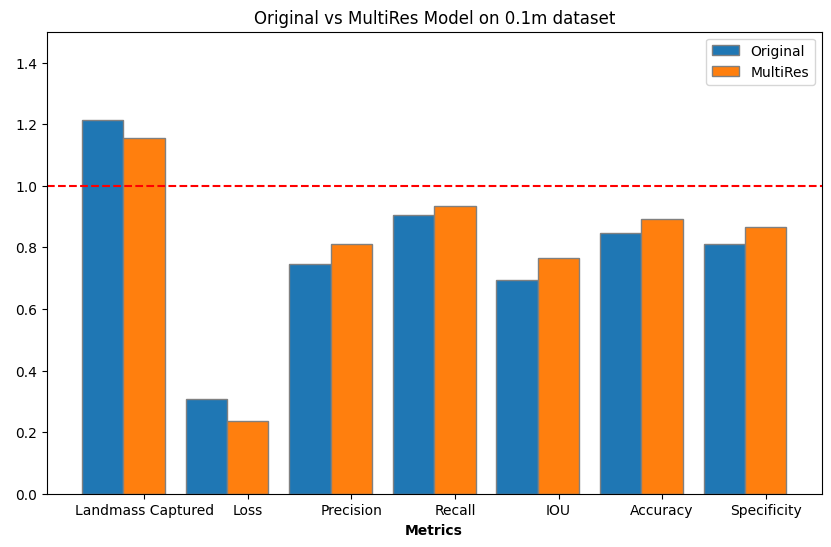

[[1.1321987385478718, 0.22713307986985767, 0.8216955591668605, 0.930322677148248, 0.774058744932356, 0.8964879026523525, 0.8756459506798383], [1.1137869912637004, 0.18579389816088393, 0.8525594840914853, 0.9495696634775912, 0.8156292128899468, 0.918179514203536, 0.89884343198719]]


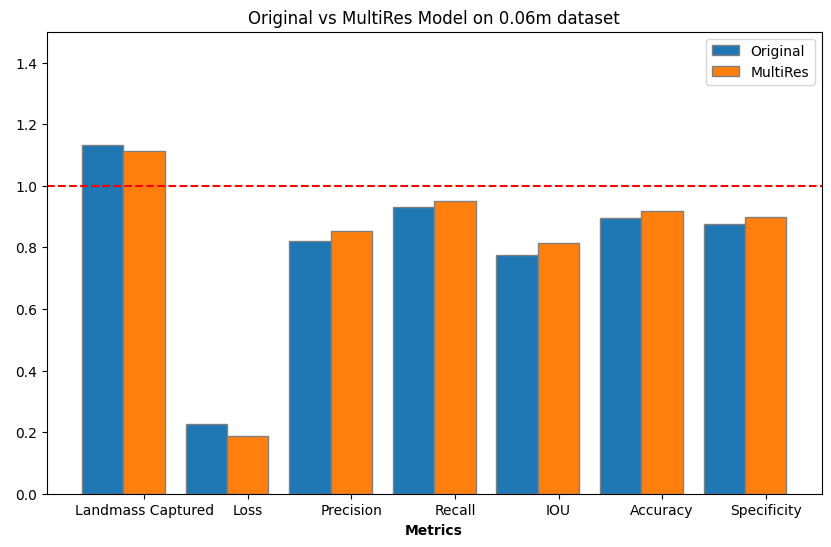

[[1.0119363281753986, 0.11330576752674322, 0.9349348419176279, 0.9460945310734352, 0.8876500561235741, 0.9569943895530604, 0.9631026115318103], [1.0386051622047754, 0.11062874058340365, 0.9244461645858224, 0.9601345582319173, 0.8902742041964739, 0.957501210352484, 0.9560254963810183]]


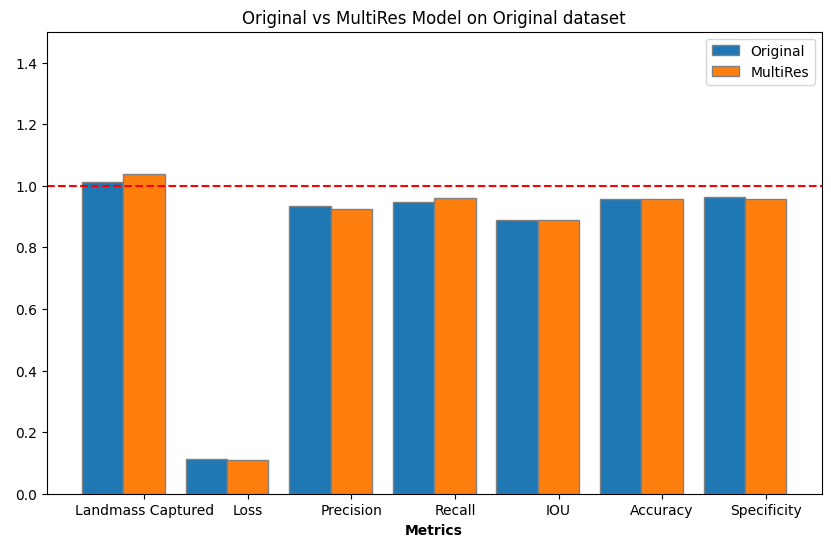

In [67]:
# compare metrics at each resolution
plot_comparison_metrics('Original vs MultiRes Model on 2m dataset', final_two_meter_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)
plot_comparison_metrics('Original vs MultiRes Model on 1m dataset', final_one_meter_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)
plot_comparison_metrics('Original vs MultiRes Model on 0.5m dataset', final_half_meter_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)
plot_comparison_metrics('Original vs MultiRes Model on 0.1m dataset', final_tenth_meter_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)
plot_comparison_metrics('Original vs MultiRes Model on 0.06m dataset', final_zero_six_meter_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)
plot_comparison_metrics('Original vs MultiRes Model on Original dataset', final_original_metrics, titles, metrics_list, y_label=' ', y_lim=1.5)

## Metric-by-metric comparison

[[1.0119363281753986, 1.1321987385478718, 1.213252030945113, 1.096751174512706, 1.5387337633665026, 0.37937295372253504], [1.0386051622047754, 1.1137869912637004, 1.153632539556335, 1.1108355913035646, 1.4534693595753854, 0.49467600484346896]]


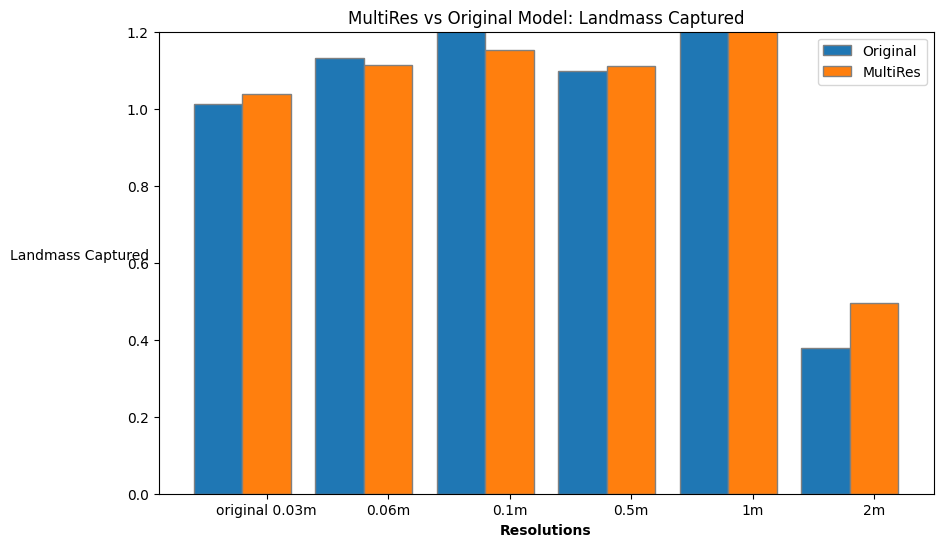

[[0.11330576752674322, 0.22713307986985767, 0.308666691893623, 0.4774756232897441, 0.5759595632553101, 0.754166305065155], [0.11062874058340365, 0.18579389816088393, 0.23531248853320166, 0.4535367290178935, 0.5364579558372498, 0.7040668725967407]]


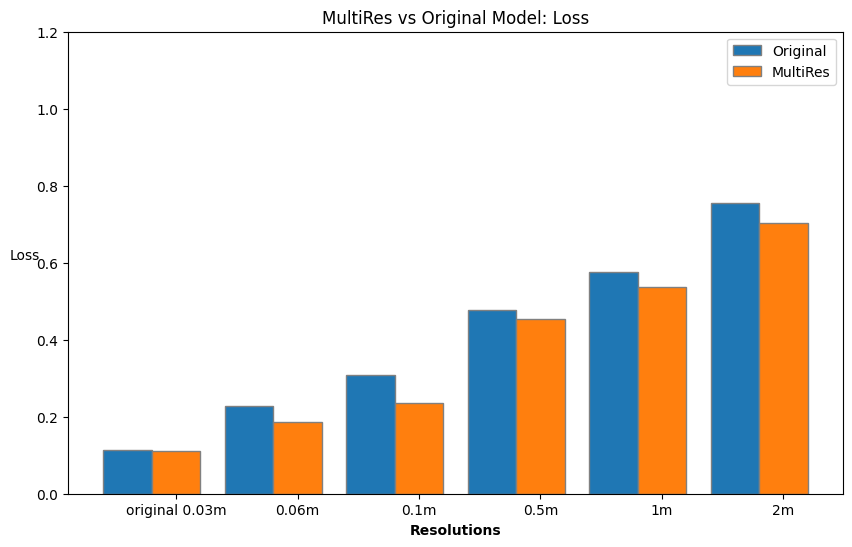

[[0.9349348419176279, 0.8216955591668605, 0.7465302772816071, 0.6713334973826764, 0.4912907850504552, 0.7174583267224182], [0.9244461645858224, 0.8525594840914853, 0.809652851035837, 0.6878415940779168, 0.5346366237443905, 0.6899812518451847]]


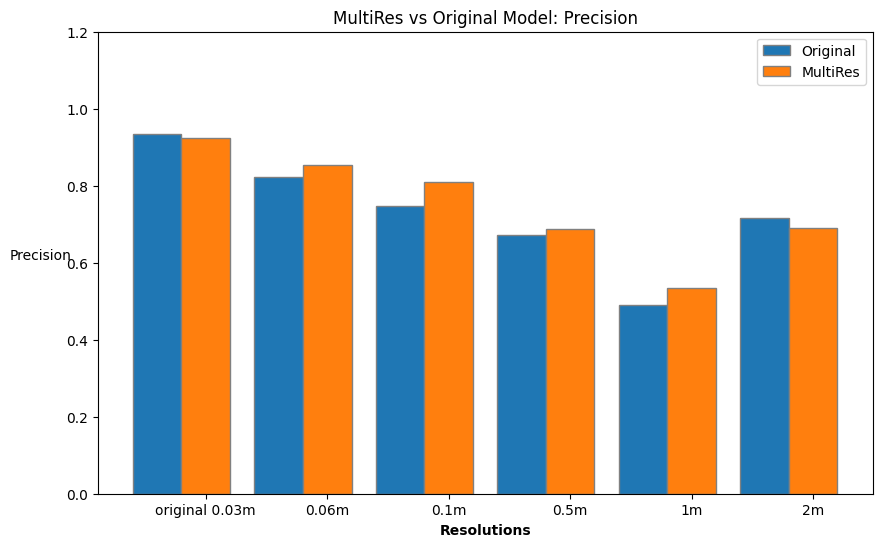

[[0.9460945310734352, 0.930322677148248, 0.9057293797950847, 0.7362858120939205, 0.755965736268223, 0.2721842928182641], [0.9601345582319173, 0.9495696634775912, 0.9340418758121796, 0.7640789184676521, 0.7770779261115303, 0.3413171373101117]]


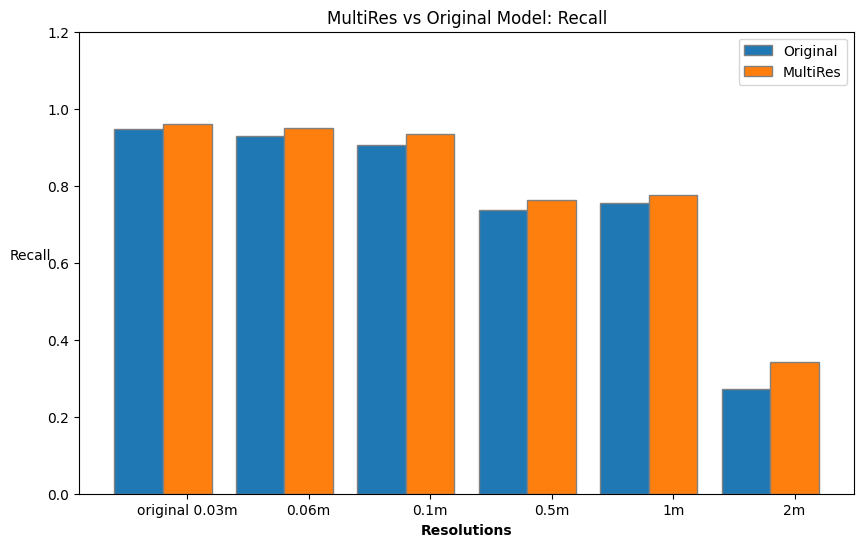

[[0.8876500561235741, 0.774058744932356, 0.6927064511025375, 0.5412014330459174, 0.4240404301161824, 0.24583370441463828], [0.8902742041964739, 0.8156292128899468, 0.765865058274682, 0.5673474194291785, 0.4635420655832125, 0.29593317443862655]]


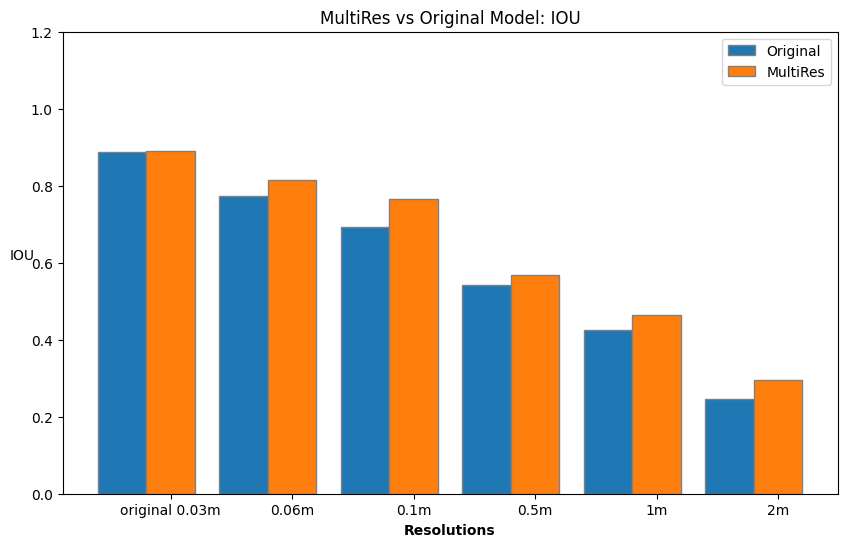

[[0.9569943895530604, 0.8964879026523525, 0.8468473127970763, 0.7416307057029725, 0.7682752254509895, 0.6225128921061611], [0.957501210352484, 0.918179514203536, 0.8911565554168037, 0.7588097260746187, 0.7970464177646213, 0.6328938032109735]]


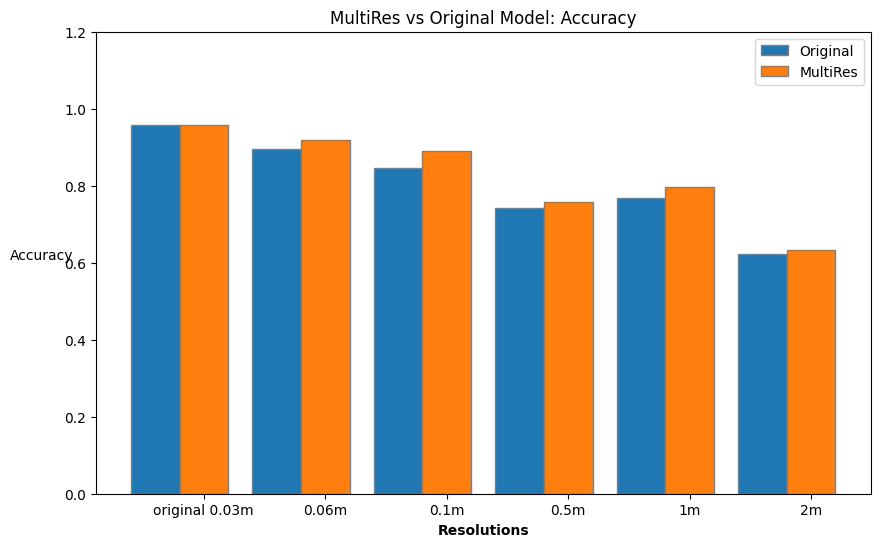

[[0.9631026115318103, 0.8756459506798383, 0.8105783079192403, 0.7454057675250756, 0.7718628171237162, 0.911561061313451], [0.9560254963810183, 0.89884343198719, 0.8647409085035619, 0.7550881314080128, 0.8028662201956333, 0.8734671086111688]]


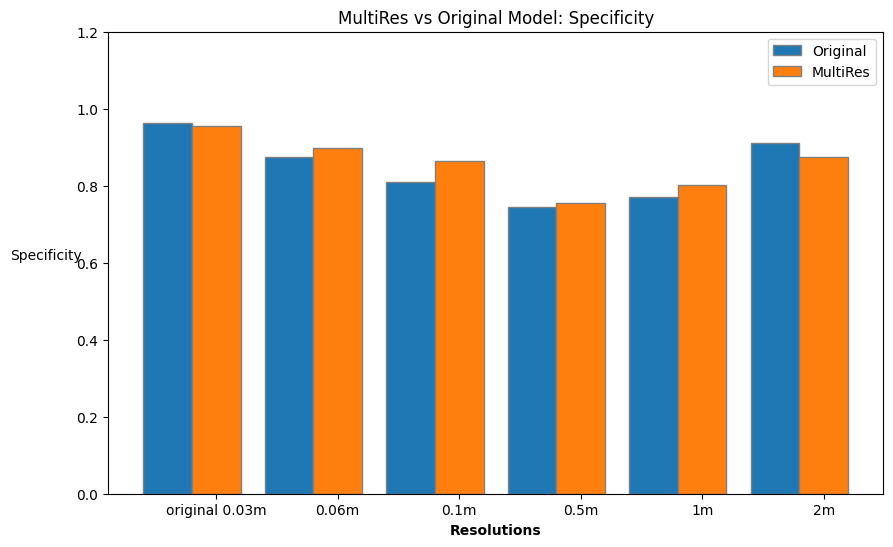

In [69]:
def compare_series_by_resolution(title: str,
                                resolutions: list[str],
                                series_to_metrics: dict[str, list[dict]],
                                metric_keys: list[str],
                                y_label: str = "Value"
                                ):
    """
    Plot per-metric comparisons across resolutions for multiple series (e.g., Original vs MultiRes).

    Args:
        title: Title for the plot.
        resolutions: x-axis labels.
        series_to_metrics: mapping series_name -> list of metrics dicts per resolution, same order as `resolutions`.
                            Example: {
                                "Original": [dict_at_res0, dict_at_res1, ...],
                                "MultiRes": [dict_at_res0, dict_at_res1, ...],
                            }
        metric_keys: which metric names to plot (e.g., ["IOU"] or ["Precision","Recall","IOU"])
        y_label: y-axis label.
    """
    # sanity checks
    n = len(resolutions)
    for s, lst in series_to_metrics.items():
        assert len(lst) == n, f"Series '{s}' length {len(lst)} != resolutions length {n}"

    for mk in metric_keys:
        # build per-series maps: {resolution -> value_for_metric}
        metrics_for_plot = []
        series_names = list(series_to_metrics.keys())
        for s in series_names:
            vals = {resolutions[i]: series_to_metrics[s][i].get(mk) for i in range(n)}
            metrics_for_plot.append(vals)   # your plotter expects List[List[dict]] and uses [-1]

        wrap = [metrics_for_plot]
        plot_comparison_metrics(
            title,
            wrap,
            titles=series_names,     # legend = series
            metrics_wanted=resolutions,  # x-axis = resolutions
            x_label="Resolutions",
            y_label=y_label,
            single_metric=False,
            y_lim=1.2
        )

# collect the *last* dict for each resolution, per series
original_series = [
    final_two_meter_metrics[0][0],
    final_one_meter_metrics[0][0],
    final_half_meter_metrics[0][0],
    final_tenth_meter_metrics[0][0],
    final_zero_six_meter_metrics[0][0],
    final_original_metrics[0][0],
]
multires_series = [
    final_two_meter_metrics[0][1],
    final_one_meter_metrics[0][1],
    final_half_meter_metrics[0][1],
    final_tenth_meter_metrics[0][1],
    final_zero_six_meter_metrics[0][1],
    final_original_metrics[0][1],
]
original_series.reverse()
multires_series.reverse()
series_to_metrics = {
    "Original": original_series,
    "MultiRes": multires_series,
}

for metric in multires_machine.get_available_metrics():
    compare_series_by_resolution(
        title=f"MultiRes vs Original Model: {metric}",
        resolutions=validation_resolutions,
        series_to_metrics=series_to_metrics,
        metric_keys=[metric],
        y_label=metric
    )